In [1]:
import zipfile
import xarray as xr
import netCDF4 as nc
import io

from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Data should be loaded from data/raw
path = "../data/raw/RSS_Windsat_TB_L1C_20170101.zip"

In [22]:
with zipfile.ZipFile(path, "r") as zip_file:
    file_list = zip_file.namelist()

    xarray_list = []

    for file_name in file_list:
        if file_name.endswith(".nc4"):
            with zip_file.open(file_name) as nc_file:
                pointer = nc_file.read()
                data = io.BytesIO(pointer)
                xarray = xr.open_dataset(
                    data, decode_times=False
                )  # timestamp are all messed up
                xarray = xarray.set_coords(["latitude", "longitude"])

                # Selec only ka and ku bands, vertical and horizontal polarization.
                # Also pass time
                variables = [
                    "tb_18",
                    "tb_37",
                    "time",
                    "quality_flag",
                    "earth_incidence_angle",
                    "scan_angle",
                    "earth_azimuth_angle",
                    "pra",
                ]
                xarray = xarray[variables]

                # Keep only H and V polarizations, also look = 0 (forward) has better coverage
                xarray["tb_18_V"] = xarray["tb_18"].sel(
                    polarization_6=0, look=0
                )  # 0 = V
                xarray["tb_18_H"] = xarray["tb_18"].sel(
                    polarization_6=1, look=0
                )  # 1 = H

                xarray = xarray.drop_vars("tb_18")

                xarray["tb_37_V"] = xarray["tb_37"].sel(
                    polarization_6=0, look=0
                )  # 0 = V
                xarray["tb_37_H"] = xarray["tb_37"].sel(
                    polarization_6=1, look=0
                )  # 1 = H

                xarray = xarray.drop_vars("tb_37")

                # Convert latitude and longitude grids into (-90, 90) and (-180, 180) degrees

                xarray_list.append(xarray)

print(len(xarray_list))
# For testing
xarr = xarray_list[0]

13


In [23]:
# time = seconds since 2000-01-01 00:00:00


def ConvertTime(seconds: float) -> datetime:
    """time = seconds since 2000-01-01 00:00:00"""
    start = datetime(2000, 1, 1, 0, 0, 0, 0)
    time_to_add = timedelta(seconds=seconds)

    corrected_time = start + time_to_add

    return corrected_time

In [ ]:
for xarr in xarray_list:
    print(xarr.time_coverage_start)
    print(xarr.time_coverage_end)
    print()

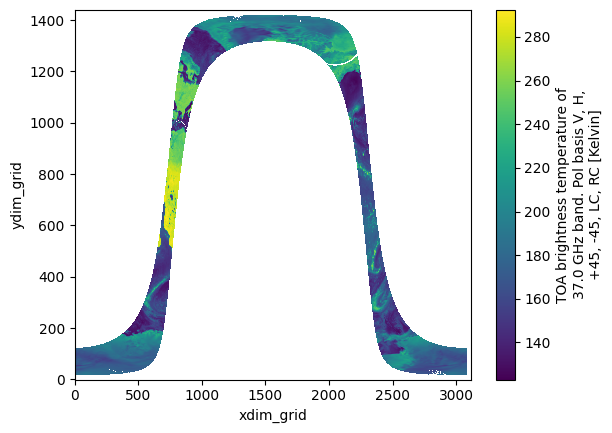

In [25]:
xarr = xarray_list[10]
KabandH = xarr["tb_37_H"]
KabandH.plot()

In [29]:
# Plot all the passes in the same plot: Tb_ka_H
ncols = 2
nrows = len(xarray_list) //2 + 1 if len(xarray_list) % 2 == 1 else len(xarray_list) //2



fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize = (10,12))
for i,xarr in enumerate(xarray_list):
    row = i //ncols
    col = i % ncols
    to_plot = xarr['tb_37_H']
    to_plot.plot(ax = ax[row,col], cmap = 'viridis', alpha = 0.3)

fig.tight_layout()

fig.show()



C:\Users\andre\AppData\Local\Temp\ipykernel_27396\1939647290.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
